In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import featuretools as ft
import featuretools.primitives as ftp

from woodwork.logical_types import Categorical

In [2]:
data = pd.read_csv('../Datasets/online_retail_dataset_all.csv')

print(data.shape)

data.head()

(741301, 3)


,invoice_date,description,revenue
0,2009-12-01 07:45:00,15CM CHRISTMAS GLASS BALL 20 LIGHTS,83.4
1,2009-12-01 07:45:00,PINK CHERRY LIGHTS,81.0
2,2009-12-01 07:45:00,WHITE CHERRY LIGHTS,81.0
3,2009-12-01 07:45:00,"RECORD FRAME 7"" SINGLE SIZE",100.8
4,2009-12-01 07:45:00,STRAWBERRY CERAMIC TRINKET BOX,30.0


In [3]:
data['invoice_date'] = pd.to_datetime(data['invoice_date'])

data.sort_values(by=['invoice_date'], inplace=True)

In [4]:
def plot_ts(df):
    df.copy()
    
    df.index = df['invoice_date']
    df['revenue'].plot(figsize=(20,5))
    plt.ylabel('Revenue')
    plt.show()

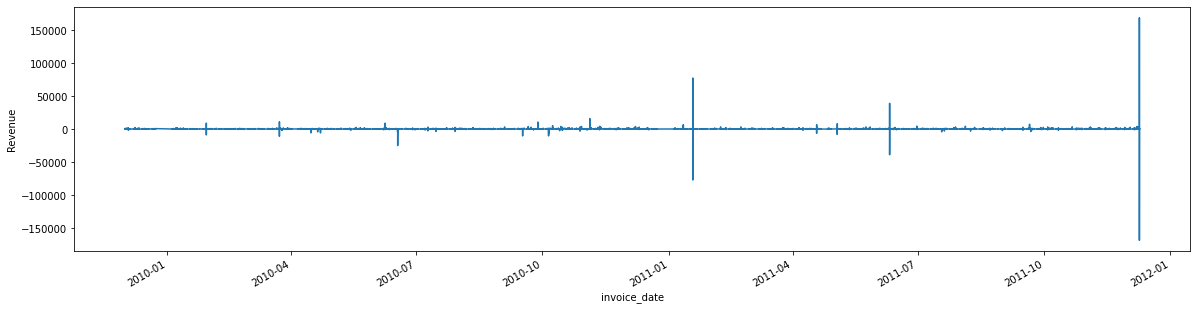

In [5]:
plot_ts(data)

These people seem to sell a lot during Christmas

In [6]:
# target

y =  data[['invoice_date', 'revenue']].resample('W', on='invoice_date').sum()

y.head()

,revenue
invoice_date,
2009-12-06,205634.58
2009-12-13,187355.56
2009-12-20,180246.40
2009-12-27,19626.59
2010-01-03,0.00


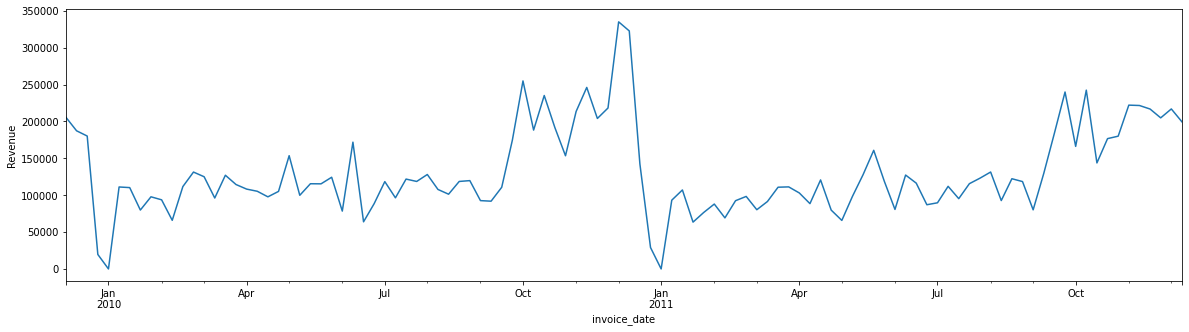

In [7]:
y = pd.DataFrame(y).reset_index()

plot_ts(y)

In [8]:
def get_weekly(df):
    
    df = df.copy()
    
    df['year'] = df['invoice_date'].dt.year
    df['week'] = df['invoice_date'].dt.isocalendar().week

    df['weekly'] = df.agg(lambda x: f"{x['year']}-{x['week']}", axis=1)
    
    t = df['weekly'].unique()

    week_maps = {k: i for i, k in enumerate(t, 0)}

    df['weekly'] = df['weekly'].map(week_maps)
    
    return df['weekly']    

In [9]:
data['weekly'] = get_weekly(data)

data.head()

,invoice_date,description,revenue,weekly
invoice_date,,,,
2009-12-01 07:45:00,2009-12-01 07:45:00,15CM CHRISTMAS GLASS BALL 20 LIGHTS,83.4,0
2009-12-01 07:45:00,2009-12-01 07:45:00,PINK CHERRY LIGHTS,81.0,0
2009-12-01 07:45:00,2009-12-01 07:45:00,WHITE CHERRY LIGHTS,81.0,0
2009-12-01 07:45:00,2009-12-01 07:45:00,"RECORD FRAME 7"" SINGLE SIZE",100.8,0
2009-12-01 07:45:00,2009-12-01 07:45:00,STRAWBERRY CERAMIC TRINKET BOX,30.0,0


In [10]:
y['weekly'] = get_weekly(y)

y.head()

,invoice_date,revenue,weekly
invoice_date,,,
2009-12-06,2009-12-06,205634.58,0
2009-12-13,2009-12-13,187355.56,1
2009-12-20,2009-12-20,180246.40,2
2009-12-27,2009-12-27,19626.59,3
2010-01-03,2010-01-03,0.00,4


In [11]:
y.columns = ['week_end_date', 'total_revenue', 'weekly']

In [12]:
# data = data.merge(y, on='weekly', how='left')

# data.head()

In [13]:
# in order for feature tools to work, we need to create
# entity sets

es = ft.EntitySet(id="sales_data")


es = es.add_dataframe(
    dataframe_name='data',
    dataframe=data,
    time_index="invoice_date",
    make_index=True,
    index='index',
)

# display the entity set
es

Entityset: sales_data
  DataFrames:
    data [Rows: 741301, Columns: 5]
  Relationships:
    No relationships

In [14]:
# now we indicate that within the entity set
# there is another table, with customer data,
# each customer identified with a unique
# customer id

es.normalize_dataframe(
    base_dataframe_name="data",
    new_dataframe_name="weekly_sales",
    new_dataframe_time_index='week_end_date',
    index="weekly")

Entityset: sales_data
  DataFrames:
    data [Rows: 741301, Columns: 5]
    weekly_sales [Rows: 104, Columns: 2]
  Relationships:
    data.weekly -> weekly_sales.weekly

In [15]:
agg_prim = ['count', 'mean', 'sum', 'max', 'std',
            'avg_time_between', 
            'entropy', 'num_unique']

# differently from the previous case, here we want to aggregate
# the information at customer level, so we want a summary view of
# each customer

# first we aggregate only the existing variables
# that is the transaction amount

# we want the mean and maximum transaction amount per customer

feature_matrix, features = ft.dfs(entityset=es,
                                  target_dataframe_name="weekly_sales",
                                  agg_primitives=agg_prim,
                                  trans_primitives=[],
                                  verbose=True)

# dataframe with the new features
feature_matrix

Built 8 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████


,AVG_TIME_BETWEEN(data.invoice_date),COUNT(data),ENTROPY(data.description),MAX(data.revenue),MEAN(data.revenue),NUM_UNIQUE(data.description),STD(data.revenue),SUM(data.revenue)
weekly,,,,,,,,
0,43.265077,10696,7.099133,1800.00,19.225372,2063,73.442525,205634.58
1,55.330503,9895,7.108776,2386.80,18.934367,2042,64.725113,187355.56
2,67.614061,8023,7.051575,960.00,22.466210,1906,45.250589,180246.40
3,236.201641,854,6.151392,888.16,22.981956,553,71.452564,19626.59
4,140.466200,3862,6.859167,2121.60,28.782631,1378,101.813939,111158.52
...,...,...,...,...,...,...,...,...
99,40.593446,13549,7.128302,1790.00,16.361049,2114,44.365728,221675.85
100,37.526226,14586,7.130448,1500.36,14.869811,2132,39.959681,216891.06
101,39.070066,14045,7.157591,2232.00,14.589329,2115,44.225479,204907.13


In [16]:
features

[<Feature: AVG_TIME_BETWEEN(data.invoice_date)>,
 <Feature: COUNT(data)>,
 <Feature: ENTROPY(data.description)>,
 <Feature: MAX(data.revenue)>,
 <Feature: MEAN(data.revenue)>,
 <Feature: NUM_UNIQUE(data.description)>,
 <Feature: STD(data.revenue)>,
 <Feature: SUM(data.revenue)>]

In [17]:
feature_matrix.reset_index(inplace=True)

feature_matrix.head()

,weekly,AVG_TIME_BETWEEN(data.invoice_date),COUNT(data),ENTROPY(data.description),MAX(data.revenue),MEAN(data.revenue),NUM_UNIQUE(data.description),STD(data.revenue),SUM(data.revenue)
0,0,43.265077,10696,7.099133,1800.00,19.225372,2063,73.442525,205634.58
1,1,55.330503,9895,7.108776,2386.80,18.934367,2042,64.725113,187355.56
2,2,67.614061,8023,7.051575,960.00,22.466210,1906,45.250589,180246.40
3,3,236.201641,854,6.151392,888.16,22.981956,553,71.452564,19626.59
4,4,140.466200,3862,6.859167,2121.60,28.782631,1378,101.813939,111158.52


In [18]:
y.head()

,week_end_date,total_revenue,weekly
invoice_date,,,
2009-12-06,2009-12-06,205634.58,0
2009-12-13,2009-12-13,187355.56,1
2009-12-20,2009-12-20,180246.40,2
2009-12-27,2009-12-27,19626.59,3
2010-01-03,2010-01-03,0.00,4


In [19]:
feature_matrix = feature_matrix.merge(y[['week_end_date', 'weekly']], on='weekly')

feature_matrix.head()

,weekly,AVG_TIME_BETWEEN(data.invoice_date),COUNT(data),ENTROPY(data.description),MAX(data.revenue),MEAN(data.revenue),NUM_UNIQUE(data.description),STD(data.revenue),SUM(data.revenue),week_end_date
0,0,43.265077,10696,7.099133,1800.00,19.225372,2063,73.442525,205634.58,2009-12-06
1,1,55.330503,9895,7.108776,2386.80,18.934367,2042,64.725113,187355.56,2009-12-13
2,2,67.614061,8023,7.051575,960.00,22.466210,1906,45.250589,180246.40,2009-12-20
3,3,236.201641,854,6.151392,888.16,22.981956,553,71.452564,19626.59,2009-12-27
4,4,140.466200,3862,6.859167,2121.60,28.782631,1378,101.813939,111158.52,2010-01-03


In [20]:
es = ft.EntitySet(id="weekly_sales")


es = es.add_dataframe(
    dataframe_name='fe_matrix',
    dataframe=feature_matrix,
    time_index="week_end_date",
    index='weekly',
)

# display the entity set
es

Entityset: weekly_sales
  DataFrames:
    fe_matrix [Rows: 104, Columns: 10]
  Relationships:
    No relationships

In [22]:
# we want the mean and maximum transaction amount per customer

feature_matrix, features = ft.dfs(entityset=es,
                                  target_dataframe_name="fe_matrix",
                                  agg_primitives=[],
                                  trans_primitives=[
                                      ftp.RollingMean(window_length=3, min_periods=3),
                                  'month'],
                                  verbose=True)

# dataframe with the new features
feature_matrix

C:\Users\Sole\Documents\Repositories\envs\fets\lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:156: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn("Only one dataframe in entityset, changing max_depth to "


Built 17 features
Elapsed: 00:00 | Progress: 100%|███████████████████████████████████████████████████


,AVG_TIME_BETWEEN(data.invoice_date),COUNT(data),ENTROPY(data.description),MAX(data.revenue),MEAN(data.revenue),NUM_UNIQUE(data.description),STD(data.revenue),SUM(data.revenue),MONTH(week_end_date),"ROLLING_MEAN(week_end_date, AVG_TIME_BETWEEN(data.invoice_date), min_periods=3)","ROLLING_MEAN(week_end_date, COUNT(data), min_periods=3)","ROLLING_MEAN(week_end_date, ENTROPY(data.description), min_periods=3)","ROLLING_MEAN(week_end_date, MAX(data.revenue), min_periods=3)","ROLLING_MEAN(week_end_date, MEAN(data.revenue), min_periods=3)","ROLLING_MEAN(week_end_date, NUM_UNIQUE(data.description), min_periods=3)","ROLLING_MEAN(week_end_date, STD(data.revenue), min_periods=3)","ROLLING_MEAN(week_end_date, SUM(data.revenue), min_periods=3)"
weekly,,,,,,,,,,,,,,,,,
0,43.265077,10696,7.099133,1800.00,19.225372,2063,73.442525,205634.58,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55.330503,9895,7.108776,2386.80,18.934367,2042,64.725113,187355.56,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,67.614061,8023,7.051575,960.00,22.466210,1906,45.250589,180246.40,12,55.403214,9538.000000,7.086495,1715.600000,20.208650,2003.666667,61.139409,191078.846667
3,236.201641,854,6.151392,888.16,22.981956,553,71.452564,19626.59,12,119.715402,6257.333333,6.770581,1411.653333,21.460844,1500.333333,60.476089,129076.183333
4,140.466200,3862,6.859167,2121.60,28.782631,1378,101.813939,111158.52,1,148.093968,4246.333333,6.687378,1323.253333,24.743599,1279.000000,72.839031,103677.170000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,40.593446,13549,7.128302,1790.00,16.361049,2114,44.365728,221675.85,10,44.328216,12399.333333,7.134625,2132.880000,16.768786,2059.333333,53.573184,207966.003333
100,37.526226,14586,7.130448,1500.36,14.869811,2132,39.959681,216891.06,11,41.042362,13424.666667,7.127158,2154.920000,16.510798,2091.333333,50.509535,220243.076667
101,39.070066,14045,7.157591,2232.00,14.589329,2115,44.225479,204907.13,11,39.063246,14060.000000,7.138781,1840.786667,15.273396,2120.333333,42.850296,214491.346667


In [21]:
# for more details in the types of features that we can create
# check the supported operations with the code below

primitives = ft.list_primitives()
primitives[primitives['type'] == 'transform']


,name,type,dask_compatible,koalas_compatible,description,valid_inputs,return_type
22,less_than,transform,True,True,Determines if values in one list are less than another list.,"<ColumnSchema (Logical Type = Datetime)>, <ColumnSchema (Semantic Tags = ['numeric'])>, <ColumnSchema (Logical Type = Ordinal)>",None
23,latitude,transform,False,False,Returns the first tuple value in a list of LatLong tuples.,<ColumnSchema (Logical Type = LatLong)>,None
24,num_words,transform,True,True,Determines the number of words in a string by counting the spaces.,<ColumnSchema (Logical Type = NaturalLanguage)>,None
25,modulo_by_feature,transform,True,True,Return the modulo of a scalar by each element in the list.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
26,greater_than_equal_to,transform,True,True,Determines if values in one list are greater than or equal to another list.,"<ColumnSchema (Logical Type = Datetime)>, <ColumnSchema (Semantic Tags = ['numeric'])>, <ColumnSchema (Logical Type = Ordinal)>",None
...,...,...,...,...,...,...,...
84,scalar_subtract_numeric_feature,transform,True,True,Subtract each value in the list from a given scalar.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
85,haversine,transform,False,False,Calculates the approximate haversine distance between two LatLong columns.,<ColumnSchema (Logical Type = LatLong)>,None
86,email_address_to_domain,transform,False,False,Determines the domain of an email,<ColumnSchema (Logical Type = EmailAddress)>,None
87,cum_sum,transform,False,False,Calculates the cumulative sum.,<ColumnSchema (Semantic Tags = ['numeric'])>,None


In [26]:


# for more details in the types of features that we can create
# check the supported operations with the code below

primitives = ft.list_primitives()
pd.options.display.max_colwidth = 500
primitives[primitives['type'] == 'aggregation']



,name,type,dask_compatible,koalas_compatible,description,valid_inputs,return_type
0,count,aggregation,True,True,"Determines the total number of values, excluding `NaN`.",<ColumnSchema (Semantic Tags = ['index'])>,None
1,time_since_last,aggregation,False,False,Calculates the time elapsed since the last datetime (default in seconds).,<ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>,None
2,any,aggregation,True,False,Determines if any value is 'True' in a list.,"<ColumnSchema (Logical Type = Boolean)>, <ColumnSchema (Logical Type = BooleanNullable)>",None
3,time_since_first,aggregation,False,False,Calculates the time elapsed since the first datetime (in seconds).,<ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>,None
4,median,aggregation,False,False,Determines the middlemost number in a list of values.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
5,std,aggregation,True,True,"Computes the dispersion relative to the mean value, ignoring `NaN`.",<ColumnSchema (Semantic Tags = ['numeric'])>,None
6,skew,aggregation,False,False,Computes the extent to which a distribution differs from a normal distribution.,<ColumnSchema (Semantic Tags = ['numeric'])>,None
7,num_true,aggregation,True,False,Counts the number of `True` values.,"<ColumnSchema (Logical Type = Boolean)>, <ColumnSchema (Logical Type = BooleanNullable)>",None
8,entropy,aggregation,False,False,Calculates the entropy for a categorical column,<ColumnSchema (Semantic Tags = ['category'])>,None
9,min,aggregation,True,True,"Calculates the smallest value, ignoring `NaN` values.",<ColumnSchema (Semantic Tags = ['numeric'])>,None


In [ ]:
data.index.min(), data.index.max()

In [ ]:
# keep the last month to test

X_train = data[data.index<='2005-03-04']
X_test = data[data.index>'2005-03-04']

X_train.shape, X_test.shape

In [ ]:
# we set it up to do expanding windows and 3 fold 
# cross-validation

tscv = TimeSeriesSplit(n_splits=3)